In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [55]:
# Load the dataset
data = pd.read_csv('data/user/user_churn.csv')
data.head()

,user_id,song_id,play_count,last_played,user_age,user_country,days_since_last_played,churn
0,india_user_0,00Srvq2BtgG9afXY9kzB1V,27,2024-03-29 11:25:10.912694,20,india,66,0
1,india_user_0,01N3UDXUKUP6e2It26WAak,5,2024-05-14 11:25:10.912733,20,india,20,0
2,india_user_0,09CnYHiZ5jGT1wr1TXJ9Zt,6,2024-05-29 11:25:10.912735,20,india,5,0
3,india_user_0,0ClPIeT6MSgfSgQ9ZrJbAq,1,2024-04-27 11:25:10.912737,20,india,37,0
4,india_user_0,0CnlKa2jjIMzG0gLN1KZbD,14,2024-03-12 11:25:10.912738,20,india,83,0


#### Creating a dummy treatment variable: received_promo

In [56]:
# Create a dummy treatment variable for receiving a promotional message
np.random.seed(42)

user_promo_status = {user_id: np.random.binomial(1, 0.3) for user_id in data['user_id'].unique()}
data['received_promo'] = data['user_id'].map(user_promo_status)

data.head()

,user_id,song_id,play_count,last_played,user_age,user_country,days_since_last_played,churn,received_promo
0,india_user_0,00Srvq2BtgG9afXY9kzB1V,27,2024-03-29 11:25:10.912694,20,india,66,0,0
1,india_user_0,01N3UDXUKUP6e2It26WAak,5,2024-05-14 11:25:10.912733,20,india,20,0,0
2,india_user_0,09CnYHiZ5jGT1wr1TXJ9Zt,6,2024-05-29 11:25:10.912735,20,india,5,0,0
3,india_user_0,0ClPIeT6MSgfSgQ9ZrJbAq,1,2024-04-27 11:25:10.912737,20,india,37,0,0
4,india_user_0,0CnlKa2jjIMzG0gLN1KZbD,14,2024-03-12 11:25:10.912738,20,india,83,0,0


In [57]:
# Selecting only users from usa due to computational cost
data_filtered = data[data['user_id'].str.contains('usa')]
data_filtered.user_id.to_list()

['usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user_0',
 'usa_user

In [58]:
# Inspecting  dataset
print(data_filtered.isnull().sum())
print(data_filtered.describe())

user_id                   0
song_id                   0
play_count                0
last_played               0
user_age                  0
user_country              0
days_since_last_played    0
churn                     0
received_promo            0
dtype: int64
         play_count      user_age  days_since_last_played         churn  \
count  20128.000000  20128.000000            20128.000000  20128.000000   
mean      45.516743     43.879620               46.088831      0.798241   
std       50.789818     13.368999               26.459869      0.401323   
min        1.000000     18.000000                1.000000      0.000000   
25%       11.000000     34.000000               23.000000      1.000000   
50%       27.000000     46.000000               46.000000      1.000000   
75%       58.000000     56.000000               69.000000      1.000000   
max      584.000000     65.000000               91.000000      1.000000   

       received_promo  
count    20128.000000  
mean       

### Propensity Score Matching Model


In [59]:
def propensity_score_matching(df, treatment_col, outcome_col, covariates):
    # train a model to estimate propensity scores
    X = df[covariates]
    y = df[treatment_col]
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X, y)
    df['propensity_score'] = model.predict_proba(X)[:, 1]

    # Match treated and untreated samples based on propensity scores
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]

    matched_control = control.iloc[(np.abs(control['propensity_score'].values[:, None] - treated['propensity_score'].values)).argmin(axis=0)]
    matched_data = pd.concat([treated, matched_control])

    return matched_data



#### Assigning covariates and matching data

In [60]:
# Define covariates for matching
covariates = ['user_age', 'play_count', 'days_since_last_played']
matched_data = propensity_score_matching(df = data_filtered,
                                         treatment_col='received_promo',
                                         outcome_col= 'churn',
                                         covariates=covariates)
matched_data

# Saving matched data
matched_data.to_csv('data/user/matched_user_data.csv', index=False)

/var/folders/zy/5chfsfsd461fc9x38r61w2xr0000gn/T/ipykernel_74755/3069662650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['propensity_score'] = model.predict_proba(X)[:, 1]


#### Fitting the model

In [61]:
#  causal inference analysis
X_matched = matched_data[covariates]
y_matched = matched_data['received_promo']

# adding constant term for OLS regression
X_matched = sm.add_constant(X_matched)
model = sm.OLS(y_matched, X_matched).fit()

# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         received_promo   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     1837.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:57:41   Log-Likelihood:                -7615.4
No. Observations:               13684   AIC:                         1.524e+04
Df Residuals:                   13680   BIC:                         1.527e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

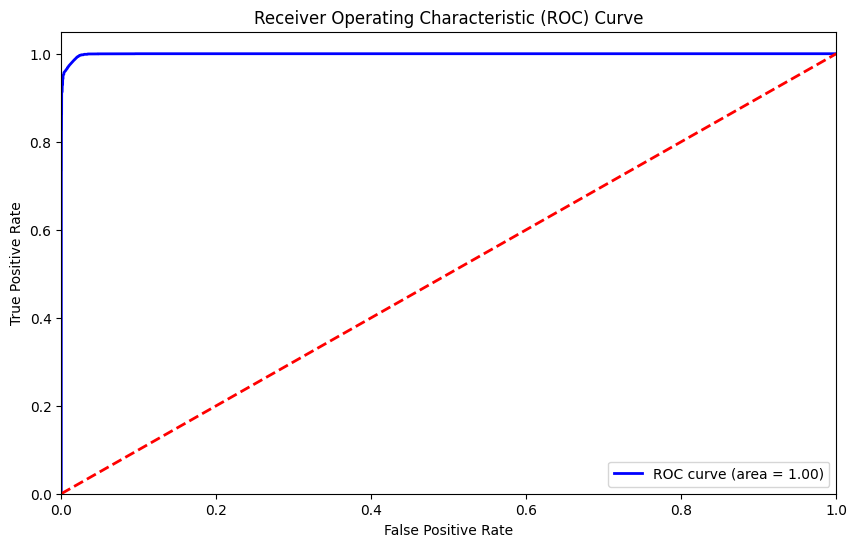

In [62]:
# plot the ROC curve for the propensity score model
fpr, tpr, thresholds = roc_curve(data_filtered['received_promo'], data_filtered['propensity_score'].dropna())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("figures/propensity_roc")
plt.show()
